In [ ]:
from __future__ import print_function

import os
import shutil
import requests


# tqdm utils

class SimpleTqdm():
    def __init__(self, iterable=None, total=None, **kwargs):
        self.iterable = list(iterable) if iterable is not None else None
        self.total = len(self.iterable) if self.iterable is not None else total
        assert self.iterable is not None or self.total is not None
        self.current_step = 0
        self.print_frequency = max(self.total // 50, 1)
        self.desc = ""

    def set_description_str(self, desc):
        self.desc = desc

    def set_description(self, desc):
        self.desc = desc

    def update(self, steps):
        last_print_step = (self.current_step // self.print_frequency) * self.print_frequency
        i = 1
        while last_print_step + i * self.print_frequency <= self.current_step + steps:
            print("*", end='')
            i += 1
        self.current_step += steps

    def close(self):
        print("\n" + self.desc)

    def __iter__(self):
        assert self.iterable is not None
        self.index = 0
        return self

    def __next__(self):
        if self.index < self.total:
            element = self.iterable[self.index]
            self.update(1)
            self.index += 1
            return element
        else:
            self.close()
            raise StopIteration

def tqdm_notebook_failsafe(*args, **kwargs):
    try:
        import tqdm
        tqdm.monitor_interval = 0  # workaround for https://github.com/tqdm/tqdm/issues/481
        return tqdm.tqdm_notebook(*args, **kwargs)
    except:
        # tqdm is broken on Google Colab
        return SimpleTqdm(*args, **kwargs)

#download utils

def download_file(url, file_path):
    r = requests.get(url, stream=True)
    total_size = int(r.headers.get('content-length'))
    try:
        with open(file_path, 'wb', buffering=16*1024*1024) as f:
            bar = tqdm_notebook_failsafe(total=total_size, unit='B', unit_scale=True)
            bar.set_description(os.path.split(file_path)[-1])
            for chunk in r.iter_content(32 * 1024):
                f.write(chunk)
                bar.update(len(chunk))
            bar.close()
    except Exception:
        print("Download failed")
    finally:
        if os.path.getsize(file_path) != total_size:
            os.remove(file_path)
            print("Removed incomplete download")

def download_google_vectors(target_dir='.'):
    print("Downloading GoogleNews-vectors-negative300.bin.gz (1.5G) for you, it will take a while...")
    download_file("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz",
                  target_dir + "/GoogleNews-vectors-negative300.bin.gz")

In [ ]:
import numpy as np


def check_embeddings(embeddings):
    error_text = "Something wrong with your embeddings ('%s test isn't correct)."
    most_similar = embeddings.most_similar(positive=['woman', 'king'], negative=['man'])
    if len(most_similar) < 1 or most_similar[0][0] != 'queen':
        return error_text % "Most similar"

    doesnt_match = embeddings.doesnt_match(['breakfast', 'cereal', 'dinner', 'lunch'])
    if doesnt_match != 'cereal':
        return error_text % "Doesn't match"

    most_similar_to_given = embeddings.most_similar_to_given('music', ['water', 'sound', 'backpack', 'mouse'])
    if most_similar_to_given != 'sound':
        return error_text % "Most similar to given"

    return "These embeddings look good."

def question_to_vec_tests(question_to_vec, wv_embeddings):
    if (np.zeros(300) != question_to_vec('', wv_embeddings)).any():
        return "You need to return zero vector for empty question."
    if (np.zeros(300) != question_to_vec('thereisnosuchword', wv_embeddings)).any():
        return "You need to return zero vector for the question, which consists only unknown words."
    if (wv_embeddings['word'] != question_to_vec('word', wv_embeddings)).any():
        return "You need to check the corectness of your function."
    if ((wv_embeddings['I'] + wv_embeddings['am']) / 2 != question_to_vec('I am', wv_embeddings)).any():
        return "Your function should calculate a mean of word vectors."
    if (wv_embeddings['word'] != question_to_vec('thereisnosuchword word', wv_embeddings)).any():
        return "You should not consider words which embeddings are unknown."
    return "Basic tests are passed."

def test_hits(hits_count):
    # *Evaluation example*
    # answers — dup_i
    answers = ["How does the catch keyword determine the type of exception that was thrown"]

    # candidates_ranking — the ranked sentences provided by our model
    candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                           "How does the catch keyword determine the type of exception that was thrown",
                           "NSLog array description not memory address",
                           "PECL_HTTP not recognised php ubuntu"]]
    # dup_ranks — position of the dup_i in the list of ranks +1
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]

    # correct_answers — the expected values of the result for each k from 1 to 4
    correct_answers = [0, 1, 1, 1]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(hits_count(dup_ranks, k), correct):
            return "Check the function."

    # Other tests
    answers = ["How does the catch keyword determine the type of exception that was thrown",
               "Convert Google results object (pure js) to Python object"]

    # The first test: both duplicates on the first position in ranked list
    candidates_ranking = [["How does the catch keyword determine the type of exception that was thrown",
                           "How Can I Make These Links Rotate in PHP"],
                          ["Convert Google results object (pure js) to Python object",
                           "WPF- How to update the changes in list item of a list"]]
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]
    correct_answers = [1, 1]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(hits_count(dup_ranks, k), correct):
            return "Check the function (test: both duplicates on the first position in ranked list)."

    # The second test: one candidate on the first position, another — on the second
    candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                           "How does the catch keyword determine the type of exception that was thrown"],
                          ["Convert Google results object (pure js) to Python object",
                           "WPF- How to update the changes in list item of a list"]]
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]
    correct_answers = [0.5, 1]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(hits_count(dup_ranks, k), correct):
            return "Check the function (test: one candidate on the first position, another — on the second)."

    # The third test: both candidates on the second position
    candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                           "How does the catch keyword determine the type of exception that was thrown"],
                          ["WPF- How to update the changes in list item of a list",
                           "Convert Google results object (pure js) to Python object"]]
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]
    correct_answers = [0, 1]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(hits_count(dup_ranks, k), correct):
            return "Check the function (test: both candidates on the second position)."

    return "Basic test are passed."

def test_dcg(dcg_score):
    # *Evaluation example*
    # answers — dup_i
    answers = ["How does the catch keyword determine the type of exception that was thrown"]

    # candidates_ranking — the ranked sentences provided by our model
    candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                           "How does the catch keyword determine the type of exception that was thrown",
                           "NSLog array description not memory address",
                           "PECL_HTTP not recognised php ubuntu"]]
    # dup_ranks — position of the dup_i in the list of ranks +1
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]

    # correct_answers — the expected values of the result for each k from 1 to 4
    correct_answers = [0, 1 / (np.log2(3)), 1 / (np.log2(3)), 1 / (np.log2(3))]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(dcg_score(dup_ranks, k), correct):
            return "Check the function."

    # Other tests
    answers = ["How does the catch keyword determine the type of exception that was thrown",
               "Convert Google results object (pure js) to Python object"]

    # The first test: both duplicates on the first position in ranked list
    candidates_ranking = [["How does the catch keyword determine the type of exception that was thrown",
                           "How Can I Make These Links Rotate in PHP"],
                          ["Convert Google results object (pure js) to Python object",
                           "WPF- How to update the changes in list item of a list"]]
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]
    correct_answers = [1, 1]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(dcg_score(dup_ranks, k), correct):
            return "Check the function (test: both duplicates on the first position in ranked list)."

    # The second test: one candidate on the first position, another — on the second
    candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                           "How does the catch keyword determine the type of exception that was thrown"],
                          ["Convert Google results object (pure js) to Python object",
                           "WPF- How to update the changes in list item of a list"]]
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]
    correct_answers = [0.5, (1 + (1 / (np.log2(3)))) / 2]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(dcg_score(dup_ranks, k), correct):
            return "Check the function (test: one candidate on the first position, another — on the second)."

    # The third test: both candidates on the second position
    candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                           "How does the catch keyword determine the type of exception that was thrown"],
                          ["WPF- How to update the changes in list item of a list",
                           "Convert Google results object (pure js) to Python object"]]
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]
    correct_answers = [0, 1 / (np.log2(3))]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(dcg_score(dup_ranks, k), correct):
            return "Check the function (test: both candidates on the second position)."

    return "Basic test are passed."

def test_rank_candidates(rank_candidates, wv_embeddings):
    questions = ['converting string to list', 'Sending array via Ajax fails']
    candidates = [['Convert Google results object (pure js) to Python object',
                   'C# create cookie from string and send it',
                   'How to use jQuery AJAX for an outside domain?'],
                  ['Getting all list items of an unordered list in PHP',
                   'WPF- How to update the changes in list item of a list',
                   'select2 not displaying search results']]
    results = [[(1, 'C# create cookie from string and send it'),
                (0, 'Convert Google results object (pure js) to Python object'),
                (2, 'How to use jQuery AJAX for an outside domain?')],
               [(0, 'Getting all list items of an unordered list in PHP'),
                (2, 'select2 not displaying search results'),
                (1, 'WPF- How to update the changes in list item of a list')]]
    for question, q_candidates, result in zip(questions, candidates, results):
        ranks = rank_candidates(question, q_candidates, wv_embeddings, 300)
        if not np.all(ranks == result):
            return "Check the function."
    return "Basic tests are passed."

In [ ]:

download_google_vectors(target_dir='.')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
import gensim
wv_embeddings = gensim.models.KeyedVectors.load_word2vec_format("/content/GoogleNews-vectors-negative300.bin.gz", limit=50000, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
'word' in wv_embeddings

True

In [ ]:
wv_embeddings.get_vector('word')

array([ 3.59375000e-01,  4.15039062e-02,  9.03320312e-02,  5.46875000e-02,
       -1.47460938e-01,  4.76074219e-02, -8.49609375e-02, -2.04101562e-01,
        3.10546875e-01, -1.05590820e-02, -6.15234375e-02, -1.55273438e-01,
       -1.52343750e-01,  8.54492188e-02, -2.70996094e-02,  3.84765625e-01,
        4.78515625e-02,  2.58789062e-02,  4.49218750e-02, -2.79296875e-01,
        9.09423828e-03,  4.08203125e-01,  2.40234375e-01, -3.06640625e-01,
       -1.80664062e-01,  4.73632812e-02, -2.63671875e-01,  9.08203125e-02,
        1.37695312e-01, -7.20977783e-04,  2.67333984e-02,  1.92382812e-01,
       -2.29492188e-02,  9.70458984e-03, -7.37304688e-02,  4.29687500e-01,
       -7.93457031e-03,  1.06445312e-01,  2.80761719e-02, -2.29492188e-01,
       -1.91650391e-02, -2.36816406e-02,  3.51562500e-02,  1.71875000e-01,
       -1.12304688e-01,  6.25000000e-02, -1.69921875e-01,  1.29882812e-01,
       -1.54296875e-01,  1.58203125e-01, -7.76367188e-02,  1.78710938e-01,
       -1.72851562e-01,  

**<font color='red'>Задание. Реализуйте функцию *question_to_vec_by_mean*, работающую по такой логике. </font>**

In [ ]:
import numpy as np

In [ ]:
def question_to_vec_by_mean(question, embeddings, dim=300):
    """
        question: a string
        embeddings: dict where the key is a word and a value is its' embedding
        dim: size of the representation

        result: vector representation for the question
    """
    ##########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ 
    ##########################
    #print(question)
    word_embeddings = []
    for word in question.split(' '):
        if word in embeddings:
            word_embeddings.append(embeddings[word])
    
    if len(word_embeddings) > 0:
        question_embedding = np.mean(word_embeddings, axis=0)
    else:
        question_embedding = np.zeros(dim)
    return question_embedding

In [ ]:
print(question_to_vec_tests(question_to_vec_by_mean, wv_embeddings))

Basic tests are passed.


In [ ]:
def hits_count(dup_ranks, k):
    """
        dup_ranks: list of ranks of the duplicates; one rank per question; 
                   length is a number of questions that we check (N); 
                   rank is a number from 1 to len(candidates for the question).
        k: number of top-ranked elements (k in Hits@k metric)

        result: return Hits@k value for the current ranking.
    """

    return np.mean((np.array(dup_ranks) <= k))

In [ ]:
def dcg_score(dup_ranks, k):
    """
        dup_ranks: list of ranks of the duplicates; one rank per question; 
                   length is a number of questions that we check (N); 
                   rank is a number from 1 to len(candidates for the question).
        k: number of top-ranked elements (k in DCG@k metric)

        result: return DCG@k value for the current ranking.
    """
    dup_ranks = np.array(dup_ranks)
    return np.mean((1/(np.log2(1 + dup_ranks)))*(dup_ranks <= k))

In [ ]:

print(test_hits(hits_count))

Basic test are passed.


In [ ]:

print(test_dcg(dcg_score))

Basic test are passed.


In [ ]:
def read_corpus(filename):
    data = []
    for line in open(filename, encoding='utf-8'):
        data.append(line.strip().split('\t'))
    return data


validation = read_corpus('/content/drive/My Drive/stackoverflow_similar_questions.zip (Unzipped Files)/data/validation.tsv')
train = read_corpus('/content/drive/My Drive/stackoverflow_similar_questions.zip (Unzipped Files)/data/train.tsv')

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def rank_candidates(question, candidates, embeddings, dim=300):
    """
        question: a string
        candidates: a list of strings (candidates) which we want to rank
        embeddings: some embeddings
        dim: dimension of the current embeddings
        
        result: a list of pairs (initial position in the list, question)
    """
    question_embedding = question_to_vec_by_mean(question, embeddings, dim=dim).reshape(1, -1)
    cosin = []
    for i in candidates:
        candidate_emb = question_to_vec_by_mean(i, embeddings, dim=dim).reshape(1, -1)
        cosin.append(cosine_similarity(question_embedding, candidate_emb))
    #print(cosin)
    initial_positions = list(range(len(candidates)))
    res = sorted(zip(initial_positions, candidates), key=lambda x: cosin[x[0]],reverse = True)
    return res





In [ ]:
print(test_rank_candidates(rank_candidates, wv_embeddings))

Check the function.


In [ ]:
wv_ranking = []
for line in validation[:10]:
    q, *ex = line
    ranks = rank_candidates(q, ex, wv_embeddings)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)



In [ ]:
for k in [1, 5, 10, 100, 500, 1000]:
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.200 | Hits@   1: 0.200
DCG@   5: 0.250 | Hits@   5: 0.300
DCG@  10: 0.279 | Hits@  10: 0.400
DCG@ 100: 0.344 | Hits@ 100: 0.700
DCG@ 500: 0.369 | Hits@ 500: 0.900
DCG@1000: 0.379 | Hits@1000: 1.000


In [ ]:
for line in validation[:3]:
    q, *examples = line
    print(q, *examples[:3])
    print()

How to print a binary heap tree without recursion? How do you best convert a recursive function to an iterative one? How can i use ng-model with directive in angular js flash: drawing and erasing

How to start PhoneStateListener programmatically? PhoneStateListener and service Java cast object[] to model WCF and What does this mean?

jQuery: Show a div2 when mousenter over div1 is over when hover on div1 depenting on if it is on div2 or not it should act differently How to run selenium in google app engine/cloud? Python Comparing two lists of strings for similarities



In [ ]:
import re
import nltk


nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from nltk.tokenize import RegexpTokenizer

#set
stop = set(stopwords.words('english'))
regexp = RegexpTokenizer('[a-z0-9]+')

In [ ]:
def text_prepare(text):
    """
        text: a string
        
        return: modified string

      """
    
    text = text.lower()
    
    text = regexp.tokenize(text)
    text = ([e for e in text if e.isalnum()])
    #print(text)
    text = [item for item in text if item not in stop]
    text = ' '.join(text)
    
    return text


In [ ]:
len(validation)

3760

In [ ]:
upgrade_validation = [[text_prepare(item) for item in j] for j in validation[:10]]

In [ ]:
wv_ranking = []
for line in upgrade_validation:
    q, *ex = line
    ranks = rank_candidates(q, ex, wv_embeddings)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)


In [ ]:
for k in [1, 5, 10, 100, 500, 1000]:
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.300 | Hits@   1: 0.300
DCG@   5: 0.363 | Hits@   5: 0.400
DCG@  10: 0.395 | Hits@  10: 0.500
DCG@ 100: 0.410 | Hits@ 100: 0.600
DCG@ 500: 0.450 | Hits@ 500: 0.900
DCG@1000: 0.460 | Hits@1000: 1.000


In [ ]:
arr = set()
for line in validation:
    for elem in line:
        arr |= set(elem.split(' '))

print(len(set(wv_embeddings.index2word) & arr)/len(arr))

0.1984275260781566


<font color='red'>**Задание. Реализуйте предложенную модель ниже.**</font>

Используйте класс nn.EmbeddingBag для построения среднего вектора представлений.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import nltk
from torch.optim import Adam

In [ ]:
def get_token_trigrams(token):
    if len(token) <= 2:
        return [token]
    else:
        
        begin = [token[:2]]
        nltk_trigrams = list(nltk.ngrams(list(token), 3))
        nltk_trigrams = [''.join(i) for i in nltk_trigrams]
        begin.extend(nltk_trigrams)
        begin.extend([token[-2:]])
        return begin

def collect_trigramms(tokens):
    trigrams = set()
    for token in tokens:
        trigrams |= set(get_token_trigrams(token))
    trigram2code = dict(zip(trigrams, range(len(trigrams))))
    return trigram2code


class TrigrammEmbeddingsModel(nn.Module):
    def __init__(self, dict_input, embedding_dim=300):
        """
        all_known_tokens : list of str
        
        embedding_dim : int
        """

        super(TrigrammEmbeddingsModel, self).__init__()
        self.col_trig = collect_trigramms(dict_input)
        self.embedding_sum = nn.EmbeddingBag(len(self.col_trig), embedding_dim, mode='mean')



        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
    
    def forward(self, token):

        receive_tr = get_token_trigrams(token)
        codes = torch.LongTensor([self.col_trig[i] for i in receive_tr if i in self.col_trig])
        return self.embedding_sum(codes, offsets = torch.LongTensor([0]))[0]
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################



In [ ]:
#loader = EmbeddingDataset(wv_embeddings)
#data_loader = DataLoader(loader, batch_size=20, shuffle=False)

model = TrigrammEmbeddingsModel(wv_embeddings.index2word)
loss = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [ ]:

batch_size = 64
losses = []
epoch = 10

In [ ]:
model.train()

TrigrammEmbeddingsModel(
  (embedding_sum): EmbeddingBag(15425, 300, mode=mean)
)

In [ ]:
for it in tqdm(range(epoch)):
    target_embeddings = torch.zeros((batch_size, 300))
    predicted_embeddings = torch.zeros((batch_size, 300))
    for i in range(batch_size):
        elem = np.random.choice(wv_embeddings.index2word)
        predicted_embeddings[i] = model(elem)
        target_embeddings[i] = torch.from_numpy(wv_embeddings[elem])
    loss(predicted_embeddings, target_embeddings).backward()
    with torch.no_grad():
        losses.append(loss(predicted_embeddings, target_embeddings)/(len(wv_embeddings.index2word)))
    optimizer.step()

100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


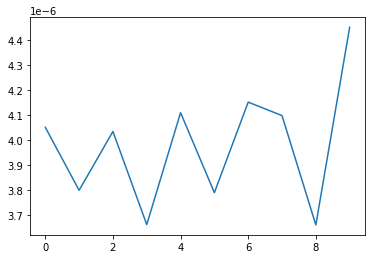

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [ ]:
   def question_to_vec_by_mean(question, embeddings, dim=300):
    """
        question: a string
        embeddings: dict where the key is a word and a value is its' embedding
        dim: size of the representation

        result: vector representation for the question
    """
    word_embeddings = []
    for word in question.split(' '):
        if word in embeddings:
            word_embeddings.append(embeddings[word])
        else:
            with torch.no_grad():
              word_embeddings.append(model(word).detach().numpy())
    
    if len(word_embeddings) > 0:
        question_embedding = np.mean(word_embeddings, axis=0)
    else:
        question_embedding = np.zeros(dim)
    return question_embedding

In [ ]:

wv_ranking = []
for line in upgrade_validation:
    q, *ex = line
    ranks = rank_candidates(q, ex, wv_embeddings)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

In [ ]:
for k in [1, 5, 10, 100, 500, 1000]:
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.400 | Hits@   1: 0.400
DCG@   5: 0.563 | Hits@   5: 0.700
DCG@  10: 0.596 | Hits@  10: 0.800
DCG@ 100: 0.617 | Hits@ 100: 0.900
DCG@ 500: 0.628 | Hits@ 500: 1.000
DCG@1000: 0.628 | Hits@1000: 1.000


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import nltk
from torch.optim import Adam


In [ ]:



class MetricDataset(Dataset):
    def __init__(self, collection, wv_embeddings):
        self._collection = [[torch.Tensor(question_to_vec_by_mean(text_prepare(token[0]),wv_embeddings)),torch.Tensor(question_to_vec_by_mean(text_prepare(token[1]),wv_embeddings))] for token in collection]
        #

    def __getitem__(self, element):
      return self._collection[element][0],self._collection[element][1], 1
      #first_random_item, second_random_item = random.sample(group_of_items, 2)
      '''if (element % (self._negative_ratio+1) == 0):
        return self._collection[element], torch.float(1)
      else:
        if (element+self._bias+self._increment>=len(self._collection)):
          res = [self._collection[element][0],(self._collection[element-(self._bias+self._increment)][0])]
          self._increment+=1
        else:
          res = [self._collection[element][0],(self._collection[element+(self._bias+self._increment)][0])]
          self._increment+=1
        return res , torch.float(0)'''
        

        
    def __len__(self):
        return len(self._collection)




In [ ]:
#upgrade_validation = [[text_prepare(item) for item in j] for j in validation[:1000]]


In [ ]:
class PairMetric(nn.Module):
    def __init__(self, input_dim=1200):
      super().__init__()
      self.Relu = nn.ReLU()
      self.Linear0 = nn.Linear(input_dim, input_dim*2)
      self.Linear1 = nn.Linear(input_dim*2,int(input_dim/4))
      self.Linear2 = nn.Linear(int(input_dim/4),int(input_dim/8))
      self.Linear3 = nn.Linear(int(input_dim/8),int(input_dim/16))
      self.Linear4 = nn.Linear(int(input_dim/16),1)
      self.Dropout = nn.Dropout(p = 0.7)
      #self.Sigmoid = nn.Sigmoid()
      self.BatchN = nn.BatchNorm1d(int(input_dim/4))
      self.BatchN2 = nn.BatchNorm1d(int(input_dim/16))
      


    def forward(self, token):
      
      result = torch.cat([token[0],token[1],torch.sub(token[0],token[1]),torch.mul(token[0],token[1])],1)
      out = self.Linear0(result)
      out = self.Relu(out)
      out = self.Linear1(out)
      out = self.BatchN(out)
      out = self.Relu(out)
      out = self.Linear2(out)
      out = self.Relu(out)
      out = self.Dropout(out)
      out = self.Linear3(out)
      out = self.BatchN2(out)
      out = self.Relu(out)
      out = self.Linear4(out)
      #out = self.Sigmoid(out)
      return out
      

In [ ]:
dataset = MetricDataset(train[:500000],wv_embeddings)
dataset_test = MetricDataset(train[500000:600000],wv_embeddings)

In [ ]:
def my_collate(batch):
  k = 8
  #print(batch)
  f,s,t= zip(*batch)
  s = list(s)
  t = list(t)
  f = list(f)
  s_new = []
  t_new = []
  for i in range(0,len(batch),k):
      for j in range(k):
        s_new.append(s[i])
        if (j==0):
          t_new.append(1)
        else:
          t_new.append(0)
  
  #print(torch.stack(f))
  #print(f[0].shape)
  #print(f)
  return torch.stack(f),torch.stack(s_new),torch.tensor([t_new], dtype = torch.float).transpose(0,1)





In [ ]:
batches = 512
epoch = 5

In [ ]:
data_loader = DataLoader(dataset, batch_size=batches, shuffle=True, collate_fn = my_collate, drop_last = True,num_workers = 2)
data_loader_test = DataLoader(dataset_test, batch_size=batches, shuffle=True, collate_fn = my_collate, drop_last = True,num_workers = 2)


loss = nn.BCEWithLogitsLoss()

model_metric = PairMetric()
def count_parameters(model):
    return sum(param.data.numpy().size for param \
               in model.parameters() if param.requires_grad)

count_parameters(model_metric)

optimizer = Adam(model_metric.parameters(), lr=0.1)

In [ ]:
!pip install barbar
from barbar import Bar

In [ ]:
all_losses_train = []
all_losses_test = []
#device ='cuda'
#model.to('cpu')

for n_epoch in (range(epoch)):
    #train part
    model_metric.train()
    mean_loss_train = 0.0
    mean_loss_test = 0.0
    print(" Epoch: {0}/{1}".format(n_epoch+1, epoch))
    print('-' * 10)
    print("TRAIN FAZE:")
    for f,s,t  in (Bar(data_loader)): 
        #f = f
        #s = s
        #t = t
        optimizer.zero_grad()
        outputs = model_metric([f,s])
        #with torch.no_grad():
         # print(outputs.cpu().numpy())
        loss_value = loss(outputs, t)
        mean_loss_train += loss_value.item()
        loss_value.backward()
        
        #mean_loss += loss_value.item()
        #train_acc += (outputs.argmax(1) == t).sum().item()/batches
        optimizer.step()
        


      #epoch_acc = train_acc/(len(data_loader))
      
    #test part
    epoch_loss_train = mean_loss_train/len(data_loader)
    print(" Loss Train: {0}".format(epoch_loss_train))
    model_metric.eval()
    print("TEST FAZE: ")
    for f_test, s_test, t_test in (Bar(data_loader_test)):
        with torch.no_grad():
          outputs_test = model_metric([f_test,s_test])
          loss_value_test = loss(outputs_test, t_test)
          mean_loss_test += loss_value_test.item()
      
    epoch_loss_test = mean_loss_test/len(data_loader_test)

    
    print(" Loss Test: {0}".format(epoch_loss_test))



    all_losses_test.append(epoch_loss_test)
    all_losses_train.append(epoch_loss_train)


 Epoch: 1/5
----------
TRAIN FAZE:
499712/500000: [===============================>] - ETA 0.4s Loss Train: 0.2412801578824149
TEST FAZE: 
 99840/100000: [===============================>] - ETA 0.1s Loss Test: 0.21644417880437314
 Epoch: 2/5
----------
TRAIN FAZE:
499712/500000: [===============================>] - ETA 0.3s Loss Train: 0.21483258380875236
TEST FAZE: 
 99840/100000: [===============================>] - ETA 0.1s Loss Test: 0.20923435153105321
 Epoch: 3/5
----------
TRAIN FAZE:
499712/500000: [===============================>] - ETA 0.4s Loss Train: 0.20830942766710384
TEST FAZE: 
 99840/100000: [===============================>] - ETA 0.1s Loss Test: 0.20139828568849807
 Epoch: 4/5
----------
TRAIN FAZE:
499712/500000: [===============================>] - ETA 0.3s Loss Train: 0.20250735889937058
TEST FAZE: 
 99840/100000: [===============================>] - ETA 0.1s Loss Test: 0.20109017300300108
 Epoch: 5/5
----------
TRAIN FAZE:
499712/500000: [======================

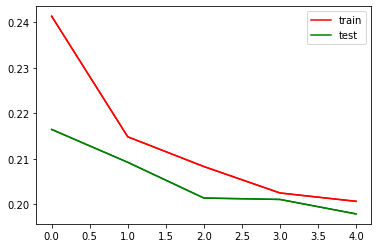

In [ ]:
import matplotlib.pyplot as plt
plt.plot(all_losses_train,'r')
plt.plot(all_losses_test,'g')
line_up, = plt.plot(all_losses_train, "r", label='train')
line_down, = plt.plot(all_losses_test, "g", label='test')
plt.legend(handles=[line_up, line_down])


In [ ]:
def rank_candidates_nn(question, candidates, embeddings, dim=300):
    """
        question: a string
        candidates: a list of strings (candidates) which we want to rank
        embeddings: some embeddings
        dim: dimension of the current embeddings
        
        result: a list of pairs (initial position in the list, question)
    """
    question_embedding = question_to_vec_by_mean(question, embeddings, dim=dim).reshape(1, -1)
    cosin = []
    for i in candidates:
        candidate_emb = question_to_vec_by_mean(i, embeddings, dim=dim).reshape(1, -1)
        #print(model_metric([torch.Tensor(question_embedding), torch.Tensor(candidate_emb)]).detach().numpy())
        cosin.append(model_metric([torch.Tensor(question_embedding), torch.Tensor(candidate_emb)]).detach().numpy())
    #print(cosin)
    initial_positions = list(range(len(candidates)))
    res = sorted(zip(initial_positions, candidates), key=lambda x: cosin[x[0]],reverse = True)
    return res


In [ ]:
upgrade_validation = [[text_prepare(item) for item in j] for j in validation[:2000]]

In [ ]:
wv_ranking = []
for line in upgrade_validation:
    q, *ex = line
    ranks = rank_candidates_nn(q, ex, wv_embeddings)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

KeyboardInterrupt: ignored

In [ ]:
for k in [1, 5, 10, 100, 500, 1000]:
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

In [ ]:
question_embedding0 = question_to_vec_by_mean(upgrade_validation[2][1], wv_embeddings, dim=300).reshape(1, -1)
question_embedding1 = question_to_vec_by_mean(upgrade_validation[1][0], wv_embeddings, dim=300).reshape(1, -1)

In [ ]:
with torch.no_grad():
  model_metric.eval()
  print(model_metric([torch.Tensor(question_embedding0), torch.Tensor(question_embedding1)]).numpy())

[[-3.2831628]]
